In [2]:

%load_ext autoreload
%autoreload 2


In [3]:
import os

import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

from utils import load_json

run_path = "my_runs/6"


ckpt_paths = [
    os.path.join(run_path, p)
    for p in os.listdir(run_path)
    if p.encode("utf-8").endswith(b".ckpt")
]

checkpoint = torch.load(ckpt_paths[0])

config = load_json(os.path.join(run_path, "config.json"))
statedict = checkpoint["state_dict"]
z_loc = statedict["z_loc"].detach().cpu().numpy()
z_scale = statedict["z_scale"].detach().cpu().numpy()
bias = statedict["bias"].detach().cpu().numpy()

In [4]:
import pandas as pd

from datasets import load_dataset
from visualization import get_pos_df

events, nodes = load_dataset(config["dataset"]).values()
pos_df = get_pos_df(z_loc, z_scale)
n_segments = nodes.shape[1]  # Number of time segments
segment_idx = pd.cut(pos_df["tick_time"], bins=n_segments, labels=False)

sizes = z_scale.sum(axis=1)

pos_df["cluster"] = nodes[pos_df["node"], segment_idx].astype(int)
pos_df["cluster"] = pos_df["cluster"].astype(int)
pos_df["size"] = sizes[pos_df["node"], pos_df["time_index"]]
pos_df

,node,time_index,value_x,value_y,tick_time,size,cluster
0,0,0,-0.061100,0.229913,0.000000,0.351708,0
1,0,1,-0.030500,0.162273,0.071429,0.341759,0
2,0,2,0.053361,0.032808,0.142857,0.386273,0
3,0,3,0.192260,0.135841,0.214286,0.357354,0
4,0,4,0.398050,0.210308,0.285714,0.414204,0
...,...,...,...,...,...,...,...
895,59,10,-0.037974,-0.033611,0.714286,0.317840,2
896,59,11,-0.058571,-0.095968,0.785714,0.350129,2
897,59,12,-0.123784,-0.084648,0.857143,0.374342,2
898,59,13,-0.117270,0.032096,0.928571,0.408815,2


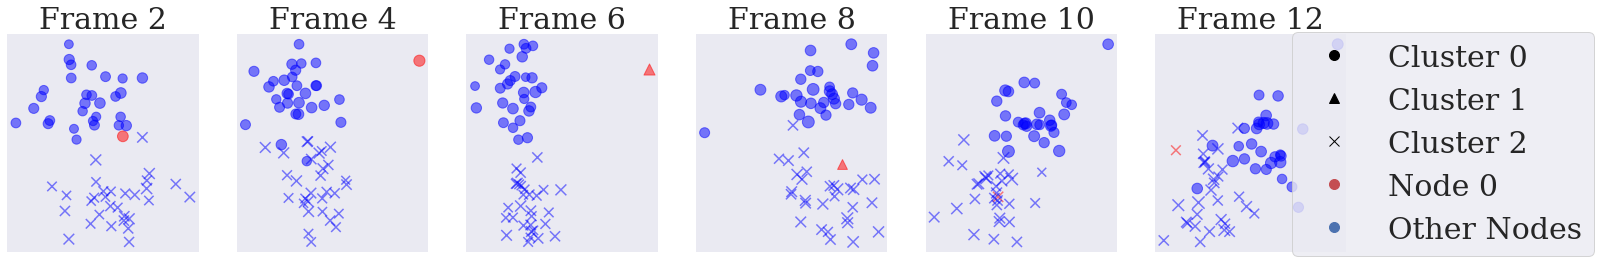

In [5]:
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

# sns.set_theme(
#     context="notebook",
#     font_scale=1.5,
#     font="serif",
#     style="darkgrid",
#     rc={  #'figure.figsize':(6.4,4.8),
#         "figure.dpi": 300,
#         "axes.spines.right": False,
#         "axes.spines.top": False,
#         "font.family": "serif",
#         # "axes.labelsize": 30,
#         # "xtick.labelsize": 14,
#         # "ytick.labelsize": 14,
#         # "legend.fontsize": 30,
#         # "axes.titlesize": 30,
#         "axes.spines.left": False,
#         "axes.spines.bottom": False,
#     },
# )
from visualization import set_theme

set_theme()

n_frames = pos_df.time_index.max() + 1
n_frames_to_plot = 6
# frames = [i * (n_frames // n_frames_to_plot) for i in range(n_frames_to_plot)]
frames = [
    2,
    # 3,
    4,
    # 5,
    6,
    # 7,
    8,
    10,
    12,
]
n_frames = len(frames)
n_clusters = len(pos_df.cluster.unique())
fig, axes = plt.subplots(1, n_frames, figsize=(n_frames * 4, 4))


def marker_map(label):
    if label == 0:
        return "o"
    elif label == 1:
        return "^"
    else:
        return "x"


pos_df["node_color"] = pos_df["node"].map(lambda x: "red" if x == 0 else "blue")
pos_df["node_marker"] = pos_df["node"].map(lambda x: "^" if x == 0 else "o")

for i, ax in enumerate(axes):
    frame_index = frames[i]
    pos_df_frame = pos_df[pos_df.time_index == frame_index]
    for cluster in range(n_clusters):
        pos_df_cluster = pos_df_frame[pos_df_frame.cluster == cluster]
        # Plot node 0 as a triangle adn the rest as circles
        pos_df_cluster.set_index("node", inplace=True)
        ax.scatter(
            pos_df_cluster.value_x,
            pos_df_cluster.value_y,
            s=pos_df_cluster["size"] * 300,
            label=f"label {cluster}",
            # c=color_map(cluster),
            c=pos_df_cluster["node_color"],
            marker=marker_map(cluster),
            # marker=pos_df_cluster["node_marker"],
            alpha=0.5,
        )

    ax.set_title(f"Frame {frame_index}")
# Remove ticks
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    # ax.legend(loc='right')


blue_star = mlines.Line2D(
    [],
    [],
    color="blue",
    marker="*",
    linestyle="None",
    markersize=10,
    label="Blue stars",
)
red_square = mlines.Line2D(
    [],
    [],
    color="red",
    marker="s",
    linestyle="None",
    markersize=10,
    label="Red squares",
)
purple_triangle = mlines.Line2D(
    [],
    [],
    color="purple",
    marker="^",
    linestyle="None",
    markersize=10,
    label="Purple triangles",
)

handles = [
    mlines.Line2D(
        [],
        [],
        color="black",
        marker=marker_map(cluster),
        linestyle="None",
        markersize=10,
        label=f"Cluster {cluster}",
    )
    for cluster in range(n_clusters)
]

# The colors represent the nodes
# Add some points to the legend

handles += [
    mlines.Line2D(
        [], [], color="r", marker="o", linestyle="None", markersize=10, label="Node 0"
    )
]
handles += [
    mlines.Line2D(
        [],
        [],
        color="b",
        marker="o",
        linestyle="None",
        markersize=10,
        label="Other Nodes",
    )
]


fig.legend(
    handles=handles,
    loc="center right",
    borderaxespad=0.4,
    bbox_to_anchor=(1.05, 0.5),
)
# plt.suptitle(
#     f"Frames on the SBM dataset, with $\sigma={config.prior_scale}$",
#     fontsize=20,
#     y=1.05,
# )
# fpath = os.path.join(FIGPATH, f"{run_id}_sbm_frames_{config.prior_scale}.pdf")
# plt.savefig(fpath, bbox_inches="tight")
# plt.legend(loc='right')
# fig, axes = plt.subplots(1, n_frames, figsize=(n_frames * 4, 4))# fig, axes = plt.subplots(1, n_frames, figsize=(n_frames * 4, 4))